In [1]:
!pip install python-dotenv==1.0.0 langchain==0.3.2 langchain-openai langchain-community langgraph==0.2.60

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [6]:
# Load environment variables
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [13]:
# Run basic query with OpenAI wrapper

from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Italian"),
    HumanMessage("hi!"),
]

llm = ChatOpenAI(model="gpt-3.5-turbo") # cheapest to try out ;)

# Simple call to model
llm.invoke(messages).pretty_print()



================================== Ai Message ==================================

Ciao!


In [14]:
# or structured
# OPENAI message format is compatible as well
llm.invoke([
    {
        "role": "user",
        "content": "Hello, how are you?",
    },
    {
        "role": "assistant",
        "content": "I'm doing well, thank you for asking.",
    },
    {
        "role": "user",
        "content": "Can you tell me a joke?",
    }
]).pretty_print()

================================== Ai Message ==================================

Sure, here's a joke for you:

Why did the scarecrow win an award?
Because he was outstanding in his field!


# Prompt Template

In [11]:
# Import prompt and define PromptTemplate

from langchain import PromptTemplate

template = """
I'm Donald Trump, president of the United States. Explain me {concept} in a couple of lines.
"""

prompt = PromptTemplate(
    input_variables=["concept"],
    template=template,
)

In [15]:
# Run LLM with PromptTemplate

llm(prompt.format(concept="milk")).pretty_print()

================================== Ai Message ==================================

Milk is a nutrient-rich liquid produced by mammals, typically cows, that is consumed by humans for its high calcium content and other essential vitamins and minerals. It is a staple in many diets and is used in a variety of culinary dishes and beverages.


In [19]:
from langchain.prompts import FewShotPromptTemplate

# Define three examples for the 3-shot learning
examples = [
    {"email_text": "You can't do it!", "category": "BS"},
    {"email_text": "Let's tax our neighbours", "category": "Economy"},
    {"email_text": "Hairdresser scheduled to tomorrow", "category": "Hairstyle"},
]
# Create a PromptTemplate for classifying emails
prompt_template = PromptTemplate(
    input_variables=["email_text", "category"],
    template="Classify the email: {email_text} /n {category}",
)
# Create a FewShotPromptTemplate using PromptTemplate and examples
few_shot_prompt = FewShotPromptTemplate(
    example_prompt=prompt_template,
    examples=examples,
    suffix="Classify the email: {email_text}",
    input_variables=["email_text"],
)

In [20]:
formatted_prompt = few_shot_prompt.format(
    email_text="Hi. I'm rescheduling my stylist"
)

llm(formatted_prompt).pretty_print()

================================== Ai Message ==================================

/n Hairstyle


# Chains

In [26]:
# Import LLMChain and define chain with language model and prompt as arguments.

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

joke = ChatPromptTemplate.from_template("tell me a joke about {topic}")

chain = prompt | joke | llm

explanation = chain.invoke({"concept": "Greenland"})

explanation.pretty_print()

================================== Ai Message ==================================

Why did Donald Trump want to buy Greenland? Because he heard it was a great place to build a wall to keep out all the icebergs!


## Another example (bit more serious now)

In [27]:
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationChain, summarize, question_answering
from langchain.schema import StrOutputParser

# Template for summarizing customer feedback
feedback_summary_prompt = PromptTemplate.from_template(
    """You are a customer service manager. Given the customer feedback, 
        it is your job to summarize the main points.
Customer Feedback: {feedback}
Summary:"""
)

# Template for drafting a business email response
email_response_prompt = PromptTemplate.from_template(
    """You are a customer service representative. Given the summary of customer feedback, 
        it is your job to write a professional email response.
Feedback Summary:
{summary}
Email Response:"""
)

feedback_chain = feedback_summary_prompt | llm | StrOutputParser()
email_chain = (
    {"summary": feedback_chain}
    | email_response_prompt
    | llm
    | StrOutputParser()
)

# Example of invoking the chain with actual customer feedback
email_chain.invoke({"feedback": "Disappointed with the late delivery and poor packaging."})


# Predefined chains: summarization and Q&A
# chain = summarize.load_summarize_chain(llm, chain_type="stuff")
# chain = question_answering.load_qa_chain(llm, chain_type="stuff")



'Dear valued customers,\n\nWe are truly sorry to hear about your recent experiences with our service. Your feedback regarding late delivery and poor packaging is extremely important to us, and we sincerely apologize for any inconvenience this may have caused.\n\nWe are actively working to address these issues promptly to ensure that they do not happen again in the future. We understand the importance of timely delivery and proper packaging in providing a positive customer experience, and we are committed to making improvements in these areas.\n\nPlease know that your satisfaction is our top priority, and we appreciate your feedback as it helps us to continuously improve our service. If you have any further concerns or feedback, please do not hesitate to reach out to us.\n\nThank you for bringing these issues to our attention, and we look forward to serving you better in the future.\n\nSincerely,\n[Your Name]\nCustomer Service Team'

# Chunking

In [29]:
# Import utility for splitting up texts and split up the explanation given above into document chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(separators=[" "],
    chunk_size = 100,
    chunk_overlap  = 0,
)
explanation ="Imagine an egg as a house for a chicken, right? But unlike real houses, this one is fragile and can break with just a tiny poke. Inside, you've got a gooey interior that eventually morphs into a cute, clucking resident. It's like nature's weirdest Airbnb!"
outputSplitted = text_splitter.split_text(explanation)

# Print the chunks
for i, chunk in enumerate(outputSplitted):
    print(f"Chunk {i+1}:\n{chunk}\n")

Chunk 1:
Imagine an egg as a house for a chicken, right? But unlike real houses, this one is fragile and can

Chunk 2:
break with just a tiny poke. Inside, you've got a gooey interior that eventually morphs into a

Chunk 3:
cute, clucking resident. It's like nature's weirdest Airbnb!



## Indexes

### Document loaders

In [30]:
from langchain.document_loaders import (
    csv_loader,
    DirectoryLoader,
    WebBaseLoader,
    JSONLoader,
    UnstructuredPDFLoader,
)

#loader = DirectoryLoader("../", glob="**/*.md")
#loader = csv_loader.CSVLoader(...)
#loader = JSONLoader(..., jq_schema="")
#loader = UnstructuredPDFLoader(...)

# Uses BeautifulSoup to crawl
!pip install bs4

loader = WebBaseLoader(
    web_path = "https://en.wikipedia.org/wiki/History_of_mathematics"
    # header_template = None,
    # verify_ssl = True,
    # proxies = None,
    # continue_on_failure = False,
    # autoset_encoding = True,
    # encoding = None,
    # web_paths = (),
    # requests_per_second = 2,
    # default_parser = "html.parser",
    # requests_kwargs = None,
    # raise_for_status = False,
    # bs_get_text_kwargs = None,
    # bs_kwargs = None,
    # session = None,
    # show_progress = True,
    # trust_env = False,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)
print(docs[0].page_content[:100])
print(docs[0].metadata)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip




History of mathematics - Wikipedia



































Jump to content







Mai
{'source': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'title': 'History of mathematics - Wikipedia', 'language': 'en'}


### Retrievers and Vectorstores

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS, Chroma, Pinecone

# Split documents into texts so that they can be imported
text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
texts = text_splitter.split_documents(docs)

## Embeddings

In [34]:
# Now let's connect to the model!
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
text_embedding = embeddings.embed_query("Birthday gifts for mathematics")

In [35]:
# Embed your texts and store them in a vectorstore
#db = FAISS.from_texts(["some_string_abc", "some_string_xyz"], embeddings)
db = FAISS.from_documents(texts, embeddings)

In [36]:
# Perform similarity search
db.similarity_search("What is Isaac Newton's contribution in math?")

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'title': 'History of mathematics - Wikipedia', 'language': 'en'}, page_content="Building on earlier work by many predecessors, Isaac Newton discovered the laws of physics that explain Kepler's Laws, and brought together the concepts now known as calculus. Independently, Gottfried Wilhelm Leibniz, developed calculus and much of the calculus notation still in use today. He also refined the binary number system, which is the foundation of nearly all digital (electronic,"),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'title': 'History of mathematics - Wikipedia', 'language': 'en'}, page_content='mathematical developments, interacting with new scientific discoveries, were made at an increasing pace that continues through the present day. This includes the groundbreaking work of both Isaac Newton and Gottfried Wilhelm Leibniz in the development of infinitesimal calc

In [37]:
# Initialize retriever and ask for relevant documents back
retriever = db.as_retriever()
retriever.invoke("What is Isaac Newton's contribution in math?")

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'title': 'History of mathematics - Wikipedia', 'language': 'en'}, page_content="Building on earlier work by many predecessors, Isaac Newton discovered the laws of physics that explain Kepler's Laws, and brought together the concepts now known as calculus. Independently, Gottfried Wilhelm Leibniz, developed calculus and much of the calculus notation still in use today. He also refined the binary number system, which is the foundation of nearly all digital (electronic,"),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'title': 'History of mathematics - Wikipedia', 'language': 'en'}, page_content='mathematical developments, interacting with new scientific discoveries, were made at an increasing pace that continues through the present day. This includes the groundbreaking work of both Isaac Newton and Gottfried Wilhelm Leibniz in the development of infinitesimal calc

In [38]:
# compressing retrieval and getting matches!
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.invoke("What is Isaac Newton's contribution in math?")
pretty_print_docs(compressed_docs)

Document 1:

Isaac Newton discovered the laws of physics that explain Kepler's Laws, and brought together the concepts now known as calculus.
----------------------------------------------------------------------------------------------------
Document 2:

Isaac Newton's contribution in math, interacting with new scientific discoveries, were made at an increasing pace that continues through the present day. This includes the groundbreaking work of both Isaac Newton and Gottfried Wilhelm Leibniz in the development of infinitesimal calculus during the course of the 17th century.
----------------------------------------------------------------------------------------------------
Document 3:

development of mathematics of local motion


## Memory (remember last summer? )

In [39]:
# One of the most important features in a LLM
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain, ConversationChain
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
prompt_memory = ChatPromptTemplate(
    [
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{text}"),
    ]
)

# Setup predefined memories
legacy_chain = LLMChain(
    llm=llm,
    prompt=prompt_memory,
    memory=memory,
)


legacy_result = legacy_chain.invoke({"text": "my name is bob"})
print(legacy_result)

legacy_result = legacy_chain.invoke({"text": "what was my name"})
print(legacy_result)

/var/folders/41/_yk6x3xn1vd5j4kvv_w7mz0r0000gp/T/ipykernel_39279/693036540.py:9: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
/var/folders/41/_yk6x3xn1vd5j4kvv_w7mz0r0000gp/T/ipykernel_39279/693036540.py:17: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  legacy_chain = LLMChain(


{'text': 'Hello Bob! How can I assist you today?', 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={}, response_metadata={})]}
{'text': 'Your name is Bob.', 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='what was my name', additional_kwargs={}, response_metadata={}), AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={})]}


## Agents and Tools (the HOT topic nowadays)

### Tools

In [42]:
from langchain_core.tools import tool
from langchain.tools import StructuredTool

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input * input

# custom function as tool
@tool
def text_processing(string: str) -> str:
    """make uppercase the text"""
    return string.upper()


tools = [magic_function, text_processing]

In [43]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("human", "{input}"),
        # Placeholders fill up a **list** of messages
        ("placeholder", "{agent_scratchpad}"),
    ]
)


agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

query = "what is the value of magic_function(3)?"
agent_executor.invoke({"input": query})


{'input': 'what is the value of magic_function(3)?',
 'output': 'The value of the magic function when the input is 3 is 9.'}

## Manage history with Langgraph

Langgraph makes easier the management of memory and is perfect for agents

In [46]:

from langgraph.prebuilt import create_react_agent

#same tools as with langchain
langgraph_agent_executor = create_react_agent(llm, tools)

query = "what is the value of magic_function(3)?" # repeated
messages = langgraph_agent_executor.invoke({"messages": [("human", query)]})
{
    "input": query,
    "output": messages["messages"][-1].content,
}

{'input': 'what is the value of magic_function(3)?',
 'output': 'The value of the magic function when the input is 3 is 9.'}

### Sure it remembers?

In [47]:
# History management
message_history = messages["messages"]

new_query = "Pardon?"

messages = langgraph_agent_executor.invoke(
    {"messages": message_history + [("human", new_query)]}
)
{
    "input": new_query,
    "output": messages["messages"][-1].content,
}

{'input': 'Pardon?',
 'output': 'The value of the magic function when the input is 3 is 9.'}

### Agents

In [48]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent

system_message = "You are a helpful assistant. Respond only in Spanish."
# This could also be a SystemMessage object
# system_message = SystemMessage(content="You are a helpful assistant. Respond only in Spanish.")

langgraph_agent_executor = create_react_agent(
    llm, tools, state_modifier=system_message
)


messages = langgraph_agent_executor.invoke({"messages": [("user", query)]})
print(
    {
        "input": query,
        "output": messages["messages"][-1].content,
    }
)

{'input': 'what is the value of magic_function(3)?', 'output': 'El valor de la función mágica con entrada 3 es 9.'}


### Customize your guidelines for answers

In [49]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant. Respond only in Spanish."),
        ("placeholder", "{messages}"),
    ]
)


def _modify_state_messages(state: AgentState):
    return prompt.invoke({"messages": state["messages"]}).to_messages() + [
        ("user", "Also say 'Baby!' after the answer.")
    ]


langgraph_agent_executor = create_react_agent(
    llm, tools, state_modifier=_modify_state_messages
)
messages = langgraph_agent_executor.invoke({"messages": [("human", query)]})
print(
    {
        "input": query,
        "output": messages["messages"][-1].content,
    }
)

{'input': 'what is the value of magic_function(3)?', 'output': '¡9! BABY!'}


## Memory

In [50]:
from langgraph.checkpoint.memory import MemorySaver  # an in-memory checkpointer
from langgraph.prebuilt import create_react_agent

system_message = "You are a funny assistant."
# This could also be a SystemMessage object
# system_message = SystemMessage(content="You are a helpful assistant. Respond only in Spanish.")

memory = MemorySaver()
langgraph_agent_executor = create_react_agent(
    llm, tools, state_modifier=system_message, checkpointer=memory
)

config = {"configurable": {"thread_id": "test-thread"}} # id to save state 
print(
    langgraph_agent_executor.invoke(
        {
            "messages": [
                ("user", "Hi, I'm polly! What's the output of magic_function of 3?")
            ]
        },
        config,
    )["messages"][-1].content
)
print("---")
print(
    langgraph_agent_executor.invoke(
        {"messages": [("user", "Remember my name?")]}, config
    )["messages"][-1].content
)
print("---")
print(
    langgraph_agent_executor.invoke(
        {"messages": [("user", "what was that output again?")]}, config
    )["messages"][-1].content
)

The output of the magic_function of 3 is 9.
---
Of course, Polly! How can I forget?
---
The output of the magic_function of 3 is 9.


### Explaining what is happening step by step

In [51]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a funny assistant."),
        ("placeholder", "{messages}"),
    ]
)


def _modify_state_messages(state: AgentState):
    return prompt.invoke({"messages": state["messages"]}).to_messages()


langgraph_agent_executor = create_react_agent(
    llm, tools, state_modifier=_modify_state_messages
)

for step in langgraph_agent_executor.stream(
    {"messages": [("human", query)]}, stream_mode="updates"
):
    print(step)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IChkBurLGRClATmhoy3UqR3h', 'function': {'arguments': '{"input":3}', 'name': 'magic_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 82, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-759d925e-49ce-48fb-8989-0658fd06cf92-0', tool_calls=[{'name': 'magic_function', 'args': {'input': 3}, 'id': 'call_IChkBurLGRClATmhoy3UqR3h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 15, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning'

#### Limit recursion (and your money...)

In [52]:
from langgraph.errors import GraphRecursionError
from langgraph.prebuilt import create_react_agent

RECURSION_LIMIT = 2 * 3 + 1

langgraph_agent_executor = create_react_agent(llm, tools=tools)

try:
    for chunk in langgraph_agent_executor.stream(
        {"messages": [("human", query)]},
        {"recursion_limit": RECURSION_LIMIT},
        stream_mode="values",
    ):
        print(chunk["messages"][-1])
except GraphRecursionError:
    print({"input": query, "output": "Agent stopped due to max iterations."})

# Set the max timeout for each step here
langgraph_agent_executor.step_timeout = 2

try:
    for chunk in langgraph_agent_executor.stream({"messages": [("human", query)]}):
        print(chunk)
        print("------")
except TimeoutError:
    print({"input": query, "output": "Agent stopped due to a step timeout."})

content='what is the value of magic_function(3)?' additional_kwargs={} response_metadata={} id='760dfd4f-ea28-4b39-8aa3-6177fadacd98'
content='' additional_kwargs={'tool_calls': [{'id': 'call_VGkPnlAOoMfnLJb9v4HVqB8z', 'function': {'arguments': '{"input":3}', 'name': 'magic_function'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 76, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-89b5b728-81db-4c1a-ba41-cd49e297e1da-0' tool_calls=[{'name': 'magic_function', 'args': {'input': 3}, 'id': 'call_VGkPnlAOoMfnLJb9v4HVqB8z', 'type': 'tool_call'}] usage_metadata={'input_tokens': 76, 'output_tokens': 15, 'total_tokens': 91, 'input_

## Human in the loop

### Interrupt

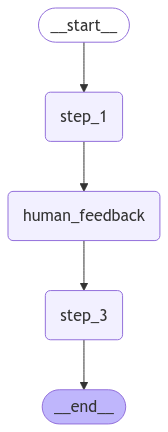

In [53]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

# Human kicks in to show who's the boss!
for event in graph.stream(
    Command(resume="go to step 3!"), thread, stream_mode="updates"
):
    print(event)
    print("\n")

graph.get_state(thread).values

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:3fca4a1b-7e3d-5760-58d8-3aeb135d0d7b'], when='during'),)}


---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




{'input': 'hello world', 'user_feedback': 'go to step 3!'}

### With an LLM Agent

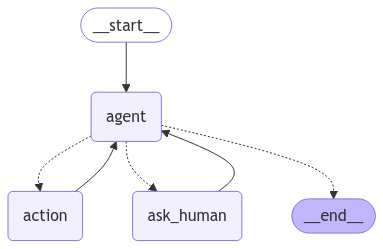

In [58]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in Paris."


tools = [search]
tool_node = ToolNode(tools)

# Set up the model: get from previous setup
model = llm

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = interrupt("Please provide your location:")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [59]:
# Call agent

config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "Use the search tool to ask the user where they are, ask each time where the user is, then look up the weather there",
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, ask each time where the user is, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  search (call_L3jjYBPTSfijagfAKgsXUsc2)
 Call ID: call_L3jjYBPTSfijagfAKgsXUsc2
  Args:
    query: Where are you?
================================= Tool Message =================================
Name: search

I looked up: Where are you?. Result: It's sunny in Paris.
================================== Ai Message ==================================
Tool Calls:
  search (call_OKNonuzi8eq4XJDenbxrVSZS)
 Call ID: call_OKNonuzi8eq4XJDenbxrVSZS
  Args:
    query: Paris weather
================================= Tool Message =================================
Name: search

I looked up: Paris weather. Result: It's sunny in Paris.
================================== Ai Message ==================================



In [60]:
app.get_state(config).next

# Give the input for the location because it is waiting for it
for event in app.stream(Command(resume="Paris"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

The weather in Paris is currently sunny.


### Search the internet and ask Human info if needed

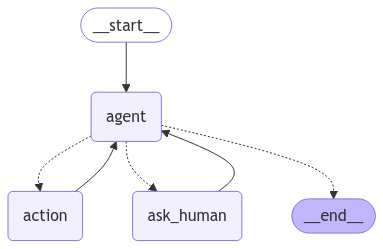

In [61]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools import TavilySearchResults

# temperature is important, otherwise model will just make assumptions and skip tool call
model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0.8)

# make a websearch with Tavily
search = TavilySearchResults(max_results=2)

tools = [search]
tool_node = ToolNode(tools)

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = interrupt("Please provide your location:")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "Use the search tool to ask the user where they are, then look up the weather there",
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_hBMLXlindeu8EmxHpiup8ofU)
 Call ID: call_hBMLXlindeu8EmxHpiup8ofU
  Args:
    question: Where are you currently located?


In [63]:
app.get_state(config).next

('ask_human',)

In [64]:
for event in app.stream(Command(resume="Badajoz"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_hBMLXlindeu8EmxHpiup8ofU)
 Call ID: call_hBMLXlindeu8EmxHpiup8ofU
  Args:
    question: Where are you currently located?
================================= Tool Message =================================

Badajoz
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_5XsYPbjiZ7cdvv2hVtez0bvk)
 Call ID: call_5XsYPbjiZ7cdvv2hVtez0bvk
  Args:
    query: weather in Badajoz
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Badajoz', 'region': 'Extremadura', 'country': 'Spain', 'lat': 38.8833, 'lon': -6.9667, 'tz_id': 'Europe/Madrid', 'localtime_epoch': 1740074127, 'localtime': '2025-02-20 18:55'}, 'current': {'last_updated_epoch': 1740073500, 'last_updated': '2025-02-20 18:45

### Review before calling certain tools

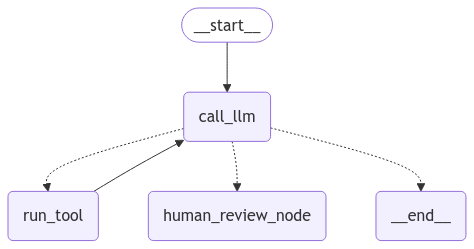

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gfhADmhR8pDT8woRiNcrSel3', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 90, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3d12de36-ce08-4a62-a862-4d36ea9db4c5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_gfhADmhR8pDT8woRiNcrSel3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 22, 'total_tokens': 112, 'input_token_details': 

In [65]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display
from langchain_community.tools import TavilySearchResults
import json

# make a websearch with Tavily
web_search = TavilySearchResults(max_results=5,
                include_answer=True,)


model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0.8).bind_tools(
    [web_search]
)


class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"tavily_search_results_json": web_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        json_data = json.dumps(tool_call, indent=2)
        print(json_data)
        tool = tools[tool_call["name"]]
        result = tool.invoke({"args": tool_call["args"], "type": "tool_call", "id": tool_call["id"], "name": tool.name})
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in san francisco?"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

In [316]:
print("Pending Executions!")
print(graph.get_state(thread).next)

for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Pending Executions!
('human_review_node',)
{'human_review_node': None}


{
  "name": "tavily_search_results_json",
  "args": {
    "query": "weather in San Francisco"
  },
  "id": "call_4oXi4XX4FRmbRtDe0BevEfHh",
  "type": "tool_call"
}
{'run_tool': {'messages': [{'role': 'tool', 'name': 'tavily_search_results_json', 'content': ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1736261591, \'localtime\': \'2025-01-07 06:53\'}, \'current\': {\'last_updated_epoch\': 1736261100, \'last_updated\': \'2025-01-07 06:45\', \'temp_c\': 13.3, \'temp_f\': 55.9, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 13.0, \'wind_kph\': 20.9, \'wind_degree\': 6, \'wind_dir\': \'N\

# Et voilà! La fin